In [1]:
# Simplified imports for single GPU
from logging import getLogger
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from memory_layers import HashingMemory, MemoryLayerMonitorAndCheckpoint, load_and_process_dataset, ModelEvaluator

logger = getLogger()

/home/sagoyal/research/finetuningmemorylayers/.venv/lib64/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
# Load Qwen0.5 Instruct
model = AutoModelForCausalLM.from_pretrained("Qwen/Qwen2.5-0.5B-Instruct", dtype=torch.float16).to(device)
tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen2.5-0.5B-Instruct", dtype=torch.float16)

# Qwen0.5 specs: 896 hidden_dim, 24 layers
hidden_dim = 896
layers_to_replace = [6, 12, 18]  # Which FFN layers to replace

Replaced layer 6 FFN with memory layer
Replaced layer 12 FFN with memory layer
Replaced layer 18 FFN with memory layer
✓ Trainable: model.layers.6.mlp.keys
✓ Trainable: model.layers.6.mlp.values.weight
✓ Trainable: model.layers.6.mlp.value_proj.weight
✓ Trainable: model.layers.6.mlp.value_proj.bias
✓ Trainable: model.layers.6.mlp.swilu_projection.weight
✓ Trainable: model.layers.6.mlp.swilu_projection.bias
✓ Trainable: model.layers.6.mlp.query_proj.query_mlps.0.weight
✓ Trainable: model.layers.6.mlp.query_proj.query_mlps.0.bias
✓ Trainable: model.layers.12.mlp.keys
✓ Trainable: model.layers.12.mlp.values.weight
✓ Trainable: model.layers.12.mlp.value_proj.weight
✓ Trainable: model.layers.12.mlp.value_proj.bias
✓ Trainable: model.layers.12.mlp.swilu_projection.weight
✓ Trainable: model.layers.12.mlp.swilu_projection.bias
✓ Trainable: model.layers.12.mlp.query_proj.query_mlps.0.weight
✓ Trainable: model.layers.12.mlp.query_proj.query_mlps.0.bias
✓ Trainable: model.layers.18.mlp.keys
✓ Tra

In [ ]:
# Load and process dataset
full_dataset = load_and_process_dataset(tokenizer, sample_size=10000)

# Split into train and eval
# Use first 1000 for evaluation, rest for training
eval_dataset = full_dataset.select(range(1000))
train_dataset = full_dataset.select(range(1000, len(full_dataset)))

print(f"Training set size: {len(train_dataset)}")
print(f"Evaluation set size: {len(eval_dataset)}")

Filtered dataset size: 7669
Tokenized dataset: Dataset({
    features: ['input_ids', 'attention_mask'],
    num_rows: 7669
})


In [ ]:
from transformers import Trainer, DataCollatorForLanguageModeling

print("📊 Evaluating Base Instruct Model Baseline...")
# Create a temporary trainer just for evaluation
base_trainer = Trainer(
    model=model,
    eval_dataset=eval_dataset,
    data_collator=DataCollatorForLanguageModeling(tokenizer, mlm=False),
)
base_metrics = base_trainer.evaluate()
print(f"Base Instruct Model Eval Loss: {base_metrics['eval_loss']:.4f}")
print(f"Base Instruct Model Perplexity: {torch.exp(torch.tensor(base_metrics['eval_loss'])):.4f}")

In [ ]:
# Replace FFNs with Memory Layers
for layer_idx in layers_to_replace:
    layer = model.model.layers[layer_idx]
    
    # Create memory layer
    memory_layer = HashingMemory(
        input_dim=hidden_dim,
        output_dim=hidden_dim,
        mem_n_keys=128,          # Memory size = 512² = 262k entries
        mem_heads=4,
        mem_knn=16,
        mem_k_dim=256,
        mem_v_dim=-1,            # Auto: uses output_dim
        swilu_projection=True,
        value_fixed_lr=0.001,
        mem_share_values=False,  # Don't share across layers for fine-tuning
    )
    
    # Initialize the memory layer
    memory_layer.reset_parameters()
    # Ensure memory layer matches model dtype (float16)
    memory_layer.to(device, dtype=model.dtype)
    
    # Replace the FFN (MLP) with memory layer
    original_mlp = layer.mlp
    layer.mlp = memory_layer
    
    print(f"Replaced layer {layer_idx} FFN with memory layer")

# FREEZE EVERYTHING EXCEPT MEMORY LAYERS
for name, param in model.named_parameters():
    if 'mlp' in name and any(f'layers.{idx}.' in name for idx in layers_to_replace):
        # This is a memory layer parameter - keep trainable
        param.requires_grad = True
        print(f"✓ Trainable: {name}")
    else:
        # Freeze all other parameters
        param.requires_grad = False

# Verify what's trainable
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in model.parameters())
print(f"\nTrainable: {trainable_params:,} / {total_params:,} ({100*trainable_params/total_params:.2f}%)")

In [ ]:
from transformers import Trainer, DataCollatorForLanguageModeling

print("📊 Evaluating Base Model With Init Memory Values...")
# Create a temporary trainer just for evaluation
base_trainer = Trainer(
    model=model,
    eval_dataset=eval_dataset,
    data_collator=DataCollatorForLanguageModeling(tokenizer, mlm=False),
)
base_metrics = base_trainer.evaluate()
print(f"Base Model With Init Memory Values Eval Loss: {base_metrics['eval_loss']:.4f}")
print(f"Base Model With Init Memory Values Perplexity: {torch.exp(torch.tensor(base_metrics['eval_loss'])):.4f}")

In [ ]:
from transformers import Trainer, TrainingArguments, DataCollatorForLanguageModeling
from memory_layers import ModelEvaluator

# Training arguments optimized for memory layers only
training_args = TrainingArguments(
    output_dir="./qwen_memory_finetuned",
    per_device_train_batch_size=4,
    gradient_accumulation_steps=4,
    num_train_epochs=2,
    learning_rate=5e-4,  # Higher LR since only training memory
    warmup_steps=100,
    lr_scheduler_type="cosine",
    logging_steps=10,
    logging_first_step=True,  # Log immediately
    logging_dir="./logs",
    save_steps=500,
    eval_strategy="steps",
    eval_steps=100,   
    # Performance
    fp16=True,
    gradient_checkpointing=False,  # Not needed with frozen base
    dataloader_num_workers=2,
    
    # Monitoring
    report_to="tensorboard",  # or "wandb" if you have it
    # load_best_model_at_end=True,
    metric_for_best_model="loss",
    save_strategy="no",
    
    # Memory optimization
    optim="adamw_torch_fused",  # Faster optimizer
    max_grad_norm=1.0,
)

data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False,
)

# Initialize Evaluator
# evaluator = ModelEvaluator(model, tokenizer, device=device)

# Initialize callback
memory_monitor = MemoryLayerMonitorAndCheckpoint(
    model=model,
    layers_to_check=layers_to_replace,
    save_every=500,
    keep_last=2,
    monitor_every=50,
    # evaluator=evaluator,
    # eval_every=50,     # Run evaluation every 100 steps
    # eval_samples=50     # Small sample size for speed during training
)

# Create trainer with callback
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=data_collator,
    callbacks=[memory_monitor],  # Add our custom monitor
)

Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [ ]:
print("\n🚀 Starting training...")
print(f"Total steps: {len(train_dataset) // (training_args.per_device_train_batch_size * training_args.gradient_accumulation_steps) * training_args.num_train_epochs}")

# Train! 
trainer.train()

print("\n✅ Training complete!")


🚀 Starting training...
Total steps: 958


Step,Training Loss,Validation Loss
100,2.011500,1.947114
200,1.846600,1.892856
300,1.916000,1.857009
400,1.847800,1.825438
500,1.721200,1.794014
600,1.804000,1.759441
700,1.898300,1.739799
800,1.872900,1.728002
900,1.775100,1.724282



🔍 MEMORY LAYER HEALTH CHECK - Step 50

📊 Layer 6 Memory:
  Parameters:
    Keys:   mean=-0.0000, std=0.0361
    Values: mean=-0.0000, std=0.0334
  Changes since start:
    Keys:   0.000852 ✅
    Values: 0.000782 ✅

📊 Layer 12 Memory:
  Parameters:
    Keys:   mean=+0.0000, std=0.0361
    Values: mean=-0.0000, std=0.0334
  Changes since start:
    Keys:   0.000811 ✅
    Values: 0.000775 ✅

📊 Layer 18 Memory:
  Parameters:
    Keys:   mean=+0.0000, std=0.0360
    Values: mean=-0.0000, std=0.0334
  Changes since start:
    Keys:   0.000817 ✅
    Values: 0.000747 ✅

✅ All memory layers healthy!


🔍 MEMORY LAYER HEALTH CHECK - Step 100

📊 Layer 6 Memory:
  Parameters:
    Keys:   mean=-0.0000, std=0.0361
    Values: mean=-0.0000, std=0.0335
  Changes since start:
    Keys:   0.002240 ✅
    Values: 0.001526 ✅

📊 Layer 12 Memory:
  Parameters:
    Keys:   mean=+0.0000, std=0.0361
    Values: mean=-0.0000, std=0.0335
  Changes since start:
    Keys:   0.002021 ✅
    Values: 0.001491 ✅

📊 Laye

In [9]:
# 1. Check actual loss history
import pandas as pd

# Extract all losses from trainer state
losses = [(log.get('step', i), log.get('loss'), log.get('eval_loss')) 
          for i, log in enumerate(trainer.state.log_history)]

df = pd.DataFrame(losses, columns=['step', 'train_loss', 'eval_loss'])
print(df)

# 2. Check if model is producing valid outputs
model.eval()
test_input = tokenizer("Hello, how are you?", return_tensors="pt").to(device)


     step  train_loss  eval_loss
0       1      2.2284        NaN
1      10      2.2150        NaN
2      20      2.0409        NaN
3      30      2.1335        NaN
4      40      2.0854        NaN
..    ...         ...        ...
102   930      1.7843        NaN
103   940      1.7414        NaN
104   950      1.7914        NaN
105   960      1.9172        NaN
106   960         NaN        NaN

[107 rows x 3 columns]


In [10]:
with torch.no_grad():
    outputs = model(**test_input)
    logits = outputs.logits
    
    print(f"\nLogits stats:")
    print(f"  Mean: {logits.mean().item()}")
    print(f"  Std: {logits.std().item()}")
    print(f"  Min: {logits.min().item()}")
    print(f"  Max: {logits.max().item()}")
    print(f"  Any NaN: {torch.isnan(logits).any().item()}")
    print(f"  Any Inf: {torch.isinf(logits).any().item()}")

# 3. Generate some text to see if model is working
generated = model.generate(**test_input, max_new_tokens=20)
print(f"\nGenerated text: {tokenizer.decode(generated[0])}")


Logits stats:
  Mean: -1.9358047246932983
  Std: 2.853154420852661
  Min: -15.609375
  Max: 22.734375
  Any NaN: False
  Any Inf: False

Generated text: Hello, how are you? I am an AI language model and I can help with a wide range of tasks. Is there anything


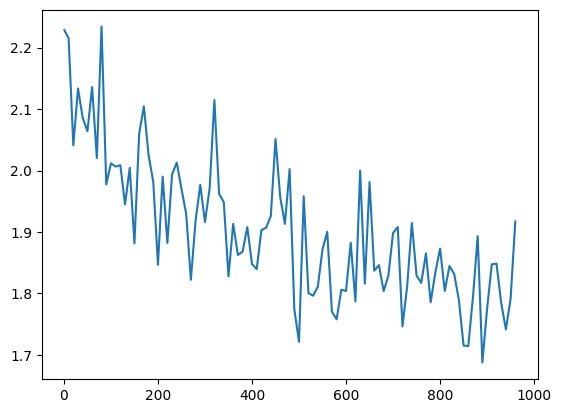

In [13]:
# Get all logged history
import matplotlib.pyplot as plt
log_history = trainer.state.log_history

# Extract just the loss entries
losses = [log['loss'] for log in log_history if 'loss' in log]
steps = [log['step'] for log in log_history if 'loss' in log]

# Plot
plt.plot(steps, losses)
plt.show()

In [ ]:
from safetensors.torch import load_file

device = "cuda" if torch.cuda.is_available() else "cpu"
hidden_dim = 896
layers_to_replace = [6, 12, 18]

# Reload model for testing
model = AutoModelForCausalLM.from_pretrained(
    "Qwen/Qwen2.5-0.5B-Instruct",
    dtype=torch.float16,
).to(device)

# Add memory layers
for idx in layers_to_replace:
    # Initialize and cast to correct device/dtype
    mem_layer = HashingMemory(
        input_dim=hidden_dim, output_dim=hidden_dim, mem_n_keys=128, mem_heads=4,
        mem_knn=16, mem_k_dim=256, mem_v_dim=-1, swilu_projection=True,
        value_fixed_lr=0.001, mem_share_values=False
    )
    # Important: Cast to model's dtype (float16) to avoid "Half and Float" errors
    model.model.layers[idx].mlp = mem_layer.to(device, dtype=model.dtype)

# Load weights
try:
    state_dict = load_file("./qwen_memory_final/model.safetensors")
except:
    state_dict = torch.load("./qwen_memory_final/pytorch_model.bin", 
                           weights_only=False)

model.load_state_dict(state_dict, strict=False)
print("\n✅ Model loaded successfully!")

# Test generation
def test_model(prompt):
    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=100,
            temperature=0.7,
            top_p=0.9,
            do_sample=True,
        )
    
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return response

# Try some prompts
# test_prompts = [
#     "Explain quantum computing in simple terms:",
#     "Write a Python function to sort a list:",
#     "What are the health benefits of exercise?",
# ]

# for prompt in test_prompts:
#     print(f"\n{'='*80}")
#     print(f"Prompt: {prompt}")
#     print(f"{'='*80}")
#     response = test_model(prompt)
#     print(response)


✅ Model loaded successfully!


In [ ]:
# Load original Qwen model for comparison
base_model = AutoModelForCausalLM.from_pretrained(
    "Qwen/Qwen2.5-0.5B-Instruct",
    torch_dtype=torch.float16,
)
base_model.to(device)

def compare_models(prompt):
    # Your fine-tuned model
    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    
    with torch.no_grad():
        # Fine-tuned
        ft_outputs = model.generate(**inputs, max_new_tokens=100)
        ft_response = tokenizer.decode(ft_outputs[0], skip_special_tokens=True)
        
        # Base
        base_outputs = base_model.generate(**inputs, max_new_tokens=100)
        base_response = tokenizer.decode(base_outputs[0], skip_special_tokens=True)
    
    print(f"\n{'='*80}")
    print(f"Prompt: {prompt}")
    print(f"{'='*80}")
    print(f"\n🔷 BASE MODEL:")
    print(base_response)
    print(f"\n🔶 FINE-TUNED (with memory layers):")
    print(ft_response)
    print(f"{'='*80}\n")

# Test
compare_models("Explain machine learning:")